In [1]:
%pip install albumentations datasets > /dev/null

In [2]:
# Import necessary libraries
import os
import sys
import gzip
import struct
from typing import List

import albumentations as albu  # Library for image augmentation
import cv2  # OpenCV library for image processing
import numpy as np
from tqdm import tqdm  # Library for progress bars

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader  # PyTorch utilities for data handling
import torchvision.models as models  # Pre-trained models provided by PyTorch

from datasets import load_dataset  # Custom function to load dataset

import matplotlib.pyplot as plt  # Library for plotting graphs and images

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
torch.manual_seed(42)  # Set random seed for reproducibility

## Dataset - [Tiny ImageNet](https://huggingface.co/datasets/zh-plus/tiny-imagenet)


In [4]:
# Load the dataset using the load_dataset function with parameters "frgfm/imagenette" and "320px".
# The "frgfm/imagenette" dataset is being loaded with images resized to 320 pixels.
dataset = load_dataset("frgfm/imagenette", "320px")

# Define the number of labels in the dataset.
num_labels = 10

# Print the dataset object.
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 9469
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 3925
    })
})

In [5]:
# Access the training split of the dataset using the key "train".
# Then, access the 124th sample (indexing is 0-based) within the training split.
# Retrieve the image data associated with the sample.
image_data = dataset["train"][123]["image"]

In [8]:
class HuggingFaceDataset(Dataset):
    """
    Define a custom dataset class named HuggingFaceDataset inheriting from the PyTorch Dataset class.
    """
    def __init__(self, dataset: Dataset, augmentations: albu.Compose, input_shape: tuple) -> None:
        # Constructor method to initialize the dataset and augmentation transformations.
        self.dataset = dataset  # Store the input dataset
        self.augs = augmentations  # Store the augmentation transformations
        self.input_shape = input_shape # Store the input shape

    def __len__(self) -> int:
        # Override the len method to return the length of the dataset.
        return len(self.dataset)

    def __getitem__(self, index) -> tuple:
        # Override the getitem method to retrieve a sample from the dataset.
        sample = self.dataset[index]  # Get the sample at the specified index from the dataset

        # Convert the image to RGB format if it's not already in that format
        image = sample["image"].convert("RGB")

        # Apply the specified augmentations to the image
        image = self.augs(image=np.array(image))["image"]

        # Convert the augmented image to a PyTorch tensor and permute its dimensions
        image = torch.from_numpy(image).permute(2, 0, 1)

        # Convert the label to a PyTorch LongTensor
        label = torch.LongTensor([sample["label"]])

        # Return the augmented image and its corresponding label as a tuple
        return image, label


In [14]:
# Set the batch size for training
batch_size = 32

# Define the input shape for the images (height, width).
# NOTE: To speed up training, you can decrease the input shape, but it may affect the final performance.
input_shape = (224, 224)

# Set the number of workers for data loading to be the number of available CPU cores
# workers = os.cpu_count() (error)
workers = 0

# Define the augmentation transformations for training images
# TODO: optional, play with augmentations
train_augs = albu.Compose([
    albu.Resize(input_shape[0], input_shape[1]), # Resize before other transformations
    albu.HorizontalFlip(p=0.5),  # Randomly flip images horizontally
    albu.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5), # Randomly shift, scale, and rotate
    albu.Normalize()  # Normalize image pixel values to a standard range
])

# Create a DataLoader for training data using the defined augmentations
train_loader = DataLoader(
    HuggingFaceDataset(dataset['train'], train_augs, input_shape=input_shape), # Pass input_shape
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
)

# Define the augmentation transformations for validation images
valid_augs = albu.Compose([
    albu.Resize(input_shape[0], input_shape[1]), # Resize before normalization
    albu.Normalize()  # Only normalize for validation
])

# Create a DataLoader for validation data using the defined augmentations
valid_loader = DataLoader(
    HuggingFaceDataset(dataset['validation'], valid_augs, input_shape=input_shape), # Pass input_shape
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers
)


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [15]:
def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: str = "cpu",
    verbose: bool = True,
) -> dict:
    """
    Function to train the model for one epoch.

    Args:
    - model: The neural network model to be trained.
    - loader: DataLoader object for loading the training data.
    - criterion: Loss function criterion.
    - optimizer: Optimizer for updating model parameters.
    - device: Device to run the model on (default is "cpu").
    - verbose: If True, print progress during training.

    Returns:
    - logs: Dictionary containing training statistics.
    """

    model.train()

    logs = {"train_loss": [], "accuracies": []}

    loop = tqdm(loader, disable=not verbose, file=sys.stdout, desc='Training')

    for batch_idx, (inputs, targets) in enumerate(loop):
        inputs, targets = inputs.to(device), targets.to(device) # Move data to the device

        optimizer.zero_grad()  # Reset gradients from the previous iteration
        outputs = model(inputs)  # Forward pass: get model predictions
        loss = criterion(outputs, targets.squeeze())  # Calculate the loss
        loss.backward()  # Backpropagation: calculate gradients
        optimizer.step()  # Update model parameters

        # Logging and progress updates
        logs["train_loss"].append(loss.item()) # Store the training loss for the batch
        _, predicted = torch.max(outputs, 1) # Get the predicted class labels
        accuracy = (predicted == targets.squeeze()).sum().item() / targets.size(0)  # Calculate the accuracy for the batch
        logs["accuracies"].append(accuracy) # Store the accuracy for the batch

        loop.set_postfix({'loss': loss.item(), 'acc': accuracy})  # Update progress bar (optional)


    # TODO: complete training function
    return logs

In [16]:
@torch.inference_mode()
def evaluate(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: str = "cpu",
    verbose: bool = True,
) -> dict:
    """
    Function to evaluate the model on the validation or test set.

    Args:
    - model: The neural network model to be evaluated.
    - loader: DataLoader object for loading the validation or test data.
    - criterion: Loss function criterion.
    - device: Device to run the model on (default is "cpu").
    - verbose: If True, print evaluation results.

    Returns:
    - logs: Dictionary containing evaluation statistics.
    """
    # TODO: complete evaluation function

    model.eval()  # Set the model to evaluation mode
    logs = {"eval_loss": [], "accuracy": 0}
    total_correct = 0
    total_samples = 0

    loop = tqdm(loader, disable=not verbose, file=sys.stdout, desc='Evaluating')

    for batch_idx, (inputs, targets) in enumerate(loop):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)  # Get model predictions
        loss = criterion(outputs, targets.squeeze())  # Calculate loss

        # Update evaluation metrics
        logs["eval_loss"].append(loss.item())
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == targets.squeeze()).sum().item()
        total_samples += targets.size(0)

        loop.set_postfix({'loss': loss.item()})

    logs["accuracy"] = total_correct / total_samples  # Calculate overall accuracy

    return logs

In [17]:
# Check if CUDA (GPU) is available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device - {device}\n")

# TODO: Find a model that gives the best score.
# Here, a pre-trained ResNet50 model is used as a starting point.
# You may experiment with other pre-trained models available in torchvision.models.
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)  # Load pre-trained ResNet18 model
model.fc = nn.Linear(model.fc.in_features, num_labels)  # Replace the fully connected layer with new output size
model = model.to(device)  # Move the model to the specified device (CPU or GPU)

print("Number of trainable parameters -", sum(p.numel() for p in model.parameters() if p.requires_grad))

# Define the optimizer for updating model parameters
optimizer = optim.Adam(model.parameters(), lr=1e-3) # Have shown great speed/efficiency in the previous HW

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

Device - cuda

Number of trainable parameters - 23528522


In [18]:
n_epochs = 20  # Number of epochs for training

train_losses = []  # List to store training losses for each epoch
train_accuracies = []  # List to store training accuracies for each epoch

valid_losses = []  # List to store validation losses for each epoch
valid_accuracies = []  # List to store validation accuracies for each epoch

# Loop through each epoch
for ep in range(n_epochs):
    print(f"\nEpoch {ep + 1:2d}/{n_epochs:2d}")

    # Train the model for one epoch and collect training statistics
    train_logs = train_one_epoch(model, train_loader, loss_fn, optimizer, device, verbose=True)
    train_losses.append(np.mean(train_logs["train_loss"]))
    train_accuracies.append(np.mean(train_logs["accuracies"]))
    print("      loss:", train_losses[-1])
    print("  accuracy:", train_accuracies[-1])

    # Evaluate the model on the validation set and collect evaluation statistics
    valid_logs = evaluate(model, valid_loader, loss_fn, device, verbose=True)
    valid_losses.append(np.mean(valid_logs["eval_loss"]))  # Append the validation loss for the epoch
    valid_accuracies.append(np.mean(valid_logs["accuracy"]))  # Append the validation accuracy for the epoch
    print("      loss:", valid_losses[-1])  # Print the validation loss for the epoch
    print("  accuracy:", valid_accuracies[-1])  # Print the validation accuracy for the epoch



Epoch  1/20
Training: 100%|██████████| 296/296 [02:00<00:00,  2.45it/s, loss=0.0787, acc=1]
      loss: 0.5018690410825247
  accuracy: 0.8475506756756757
Evaluating: 100%|██████████| 123/123 [00:20<00:00,  6.03it/s, loss=0.149]
      loss: 0.4558552407576301
  accuracy: 0.8662420382165605

Epoch  2/20
Training: 100%|██████████| 296/296 [01:58<00:00,  2.49it/s, loss=0.0657, acc=1]
      loss: 0.3073096444100343
  accuracy: 0.9042440878378378
Evaluating: 100%|██████████| 123/123 [00:21<00:00,  5.77it/s, loss=0.11]
      loss: 0.3281678314419176
  accuracy: 0.8970700636942676

Epoch  3/20
Training: 100%|██████████| 296/296 [01:59<00:00,  2.48it/s, loss=0.2, acc=0.897]
      loss: 0.26347929628163175
  accuracy: 0.9187805801491146
Evaluating: 100%|██████████| 123/123 [00:20<00:00,  5.92it/s, loss=0.577]
      loss: 0.3754659452990485
  accuracy: 0.8848407643312102

Epoch  4/20
Training: 100%|██████████| 296/296 [01:59<00:00,  2.48it/s, loss=0.0987, acc=0.966]
      loss: 0.206637565380063

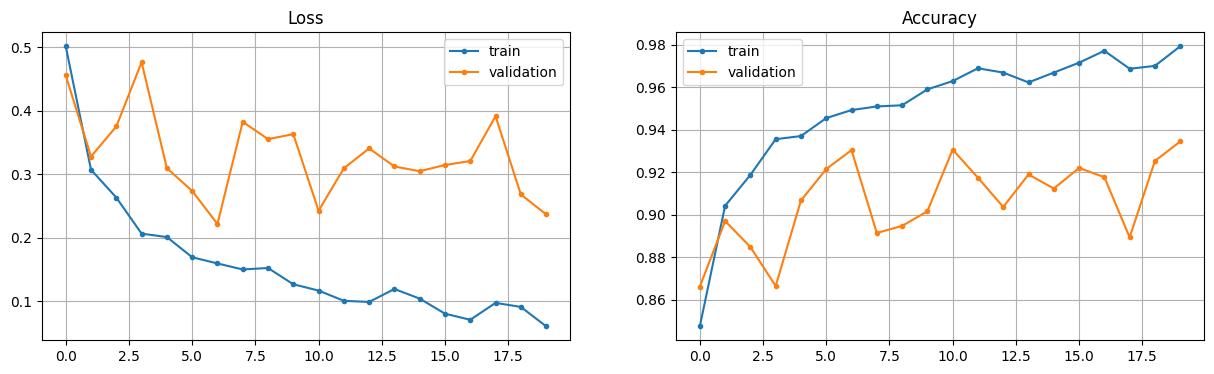

In [19]:
# Create a figure with two subplots side by side
fix, axes = plt.subplots(ncols=2, figsize=(15, 4))

# Plot the training and validation losses on the first subplot (axes[0])
axes[0].plot(np.arange(len(train_losses)), train_losses, ".-")  # Plot training losses
axes[0].plot(np.arange(len(valid_losses)), valid_losses, ".-")  # Plot validation losses
axes[0].legend(["train", "validation"])  # Add legend to distinguish between training and validation losses
axes[0].set_title("Loss")  # Set title for the subplot as "Loss"
axes[0].grid()  # Add grid lines to the plot

# Plot the training and validation accuracies on the second subplot (axes[1])
axes[1].plot(np.arange(len(train_accuracies)), train_accuracies, ".-")  # Plot training accuracies
axes[1].plot(np.arange(len(valid_accuracies)), valid_accuracies, ".-")  # Plot validation accuracies
axes[1].legend(["train", "validation"])  # Add legend to distinguish between training and validation accuracies
axes[1].set_title("Accuracy")  # Set title for the subplot as "Accuracy"
axes[1].grid();  # Add grid lines to the plot